# Convolutional networks





CNN (Convolutional neural network) has the general structure as follows:

1. Inputs are often a set of images. Each input submits into the CNN is one image. According to different structures as well as different purposes, a CNN can take one grey scale planar or 3 RGB/YUV planar as input.
2. Outputs are the probabilities of the classes that the input image belongs to. Output layer is often the sigmoid or softmax layer that full connect to the last hidden layer.
3. There are often a number of hidden layer for extracting different levels features. The hidden layer that is near to the inputs can extract lower level features, and the layer that is near to the output layer extract higher level features in contrast. At the end of CNN, the output layer makes use of such high level features to classify images.


## Feature extraction

So, what is the features of image? For instance, the color, horizonal lines, vertical lines, etc. In the field of image processing, we can use different filters to extract these features. Whereas in CNN, we leave it to the network to determine the filters.

In practice, filter is a matrix that consist of different weights. The inner product between these weights and the points in the *local receptive field*, which is a block with the same size as the filter in the image, yields an activation. And after subsequent evaluation of activation function we can obtain the feature. Using a filter to extract the features of an image, which is a convolution of the image pixel intensities with a filter comprising the weight parameters, gives a *feature map*. The layer for feature extraction is therefore called convolutional layer.

The convolution of filter and image can be interpreted in the neural network prespective. Consider a feature map whose activations are the convolution of a $n\times n$ weight filter and a single image plane. Each unit in the feature map has $\underbrace{n\times n}_{\text{filter size}}+\underbrace{1}_{\text{bias}}$ connections to the image. But there is a constrain that the weights are shared by all the units. The structure with respect to eath weight is the same , except that takes different inputs, and can be shown in a simple form as follows

$$\begin{array}{ll}
z_1 \xrightarrow[]{\qquad w\qquad} a_1\\
z_2 \xrightarrow[]{\qquad w\qquad} a_2\\
z_3 \xrightarrow[]{\qquad w\qquad} a_3
\end{array}$$

Then the derivatives with respcet to these weights are given by

$$\begin{align*}
\frac{\partial E}{\partial w} &= \sum_{a\in A_w} \frac{\partial E}{\partial a}\frac{\partial a}{\partial w}\qquad \text{multivariable chain rule}\\
&=\sum_{z\in Z_w, \delta\in D_w}\delta z
\end{align*}$$

where 
- $A_w$ is a set of activations that are contributed by the weight $w$. Generally, all the activations in the feature map satisfy such condition.
- $D_w$ is the set of derivatives of error function with respect to the activations in $A_w$. Such derivatives are known as 'error' in backpropagation.
- $Z_w$ is a set of inputs in the other end of the connection whose weight is $w$. For a single connection, there is a pair of input and error at two ends of the connection respectively.

Most CNN have multiple layers. The inputs of the layer therefore includes not only the images but also the feature maps in the previous layer. 

Moreover, there are often multiple feature maps in one layer. As a result, one feature map can take numbers of feature maps in the previous layer as inputs and each input feature map is convolved by individual filters, and then the results sum up to obtain the current feature map.

The activation of a neuron in a feature map is given by

$$z_{i,j,k} = b_k+\sum_{n=1}^{f_h}\sum_{v=1}^{f_w}\sum_{k'=1}^{f_{n'}}x_{i+u-1,j+v-1,k'}\cdot w_{u,v,k',k}$$

- $f_h$ and $f_w$ are the height and width of the receptive field, and $f_{n'}$ is the number of feature maps in the previous ($l-1$) layer.
- $z_{i,j,k}$ is the output of the neuron located in row $i$, column $j$ in feature map $k$ of the convolutional layer $l$.
- $x_{i+u-1,j+v-1,k'}$ is the output of the neuron located in layer $l-1$, row $i+u-1$, column $j+v-1$, feature map $k'$.
- $b_k$ is the bias term for feature map $k$ in layer $l$.
- $w_{u,v,k',k}$ is the weight located in row $u$, column $v$ of the shared weights matrix that corresponds to the connection between feature map $k$ of the layer $l$ and its input feature map $k'$.



## Subsampling

Subsampling are also known as pooling. The goal of subsampling is to subsample the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting). Reducing the input image size also makes the neural network tolerate a little bit of image shift (location invariance).

In practical architecture, there may be several pairs of convolutional and subsampling layers.

--------------------

# Initialization of weights and inputs

In the following practice, we will use tanh as the activation function. The tanh derivative with respect to the activation will drop to 0 when the activation is far from the origin. 

$$\left.\begin{array}{rr}
tanh'(a) \simeq 0 \ \text{ for } |a| \gg 0\\
\delta_j = tanh'(a_j)\sum_k w_{kj} \delta_k
\end{array}\right\}
\Rightarrow
\delta_j \simeq 0 \ \text{ for } |a_j| \gg 0$$

As a result, the error can not propagate back to the previous layer to refresh weights. Such gradient vanishing problem suggests us to control the inputs and the weights for keeping backpropagation work well.

## Inputs normalization

We would prefer dividing the inputs by a constant to keep the absolute value of the inputs not larger that $1$.

## Weights initialization

In general, it can be shown that the variance of the outputs linearly scales with the number of inputs, and therefore the standard deviation scales with the square root of the number of inputs. To balance this fact, each weight is initialized to a value drawn from a Gaussian distribution with standard derivation $\sqrt{1/r}$, where $r$ is the number of inputs to that neuron. Bias neurons are always initialized to zero weight.


# Gradient descent strategies

CNN may suffer severe gradient vanishing while using the stocastic gradient descent algorithm for which batch size is 1.

More will be discussed in later deep-learning notes.

-----------------------

In [2]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784')

X, y = mnist["data"], mnist["target"]
print(X.shape)

(70000, 784)


(70000, 784)
3


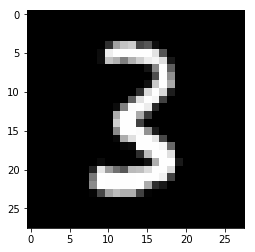

In [5]:
images = X.reshape(X.shape[0],28,28)
plt.imshow(images[50000], cmap=plt.cm.gray, interpolation='nearest')
print(X.shape)
print(y[50000])

In [198]:
# CNN for mnist
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import time
import warnings

# convert warnings to error
warnings.filterwarnings("error")

# learning rate
LR = 1.0
# learning times
LT = 1

NETWORK = None

BATCH_SIZE = 10
EPOCH_SIZE = 20000

step = 1.0/(EPOCH_SIZE*LT)
progress = 0.0
start_time = 0.0

def show_progress():
    global progress
    global start_time
    total_time = 0
    res_time = 0
    if progress == 0.0:
        start_time = time.time()
    else:
        interval = time.time() - start_time
        total_time = int(interval/progress)
        res_time = total_time - int(interval)
    progress += step
    print("\r training progress [{:.2f}%], estimated total time {:02d}h:{:02d}m, remaining time {:02d}h:{:02d}m"\
          .format(progress*100, total_time//3600, (total_time%3600)//60, res_time//3600, (res_time%3600)//60),  end='')
    

def tanh(a):
    #x1 = np.exp(a)
    #x2 = np.exp(-a)
    #y = (x1-x2)/(x1+x2)
    y = np.tanh(a)
    return y

def dtanh(o):
    y = 1-o**2
    return y

def relu(a):
    if a < 0:
        y = 0
    else:
        y = a
    return y

def drelu(o):
    if o < -1:
        y = 0
    else:
        y = 1
    return y

def linear(a):
    return a

def dlinear(o):
    return 1

def compute_weights_error(derivatives, variance):
    ret = LR * variance * derivatives
    return ret

class FeatureMap:
    layer = None
    index = -1
    weights = None
    outputs = None
    errors = None
    derivatives = None
    variance = 0.0
    act_func = None
    link_func = None
    patch_width = 0
    w = 0
    h = 0
    
    bias = 0.0
    bias_derivative = 0.0
    
    def __init__(self, patch_width, afunc=tanh, lfunc=dtanh):
        self.act_func = afunc
        self.link_func = lfunc
        self.patch_width = patch_width
    
    def build_connection(self, layer, index):
        self.layer = layer
        self.index = index
        prev_map = layer.prev_layer.sampling_maps[0]
        self.w = prev_map.w + 1 - self.patch_width
        self.h = prev_map.h + 1 - self.patch_width
        self.outputs = np.zeros((self.w, self.h))
        self.errors = np.zeros((self.w, self.h))
        self.variance = 1.0/(layer.prev_layer.map_counts * (self.patch_width**2+1))
        
        k = layer.prev_layer.map_counts
        self.weights = np.random.normal(0,\
                                        np.sqrt(self.variance),\
                                        (k, self.patch_width, self.patch_width))
        self.derivatives = np.zeros((k, self.patch_width, self.patch_width))
        
    def FP(self):
        prev_layer = self.layer.prev_layer
        self.input_maps = prev_layer.sampling_maps
        
        # convolute to obtain feature map in this layer
        for ih in range(self.h):
            for iw in range(self.w):
                # for each feature
                s = 0.0
                for k in range(len(self.input_maps)):
                    for i in range(self.patch_width):
                        for j in range(self.patch_width):
                            s += self.weights[k][i][j] * self.input_maps[k].outputs[ih+i][iw+j]
                    s += self.bias
                self.outputs[ih][iw] = self.act_func(s)
        
    def BP(self, update_weight):
        next_layer = self.layer.next_layer
        if next_layer == self.layer.network.output_layer:
            # output layer is 1-D
            s = 0.0
            for k in range(next_layer.unit_number):
                s += next_layer.weights[k][self.index] * next_layer.errors[k]
            self.errors[0][0] = self.link_func(self.outputs[0][0]) * s
        else:
            sm = self.layer.sampling_maps[self.index]
            for ih in range(self.h):
                for iw in range(self.w):
                    self.errors[ih][iw] = self.link_func(self.outputs[ih][iw])\
                        * sm.errors[ih//sm.sample_width][iw//sm.sample_width] * sm.weight

        # calculate derivatives
        for i in range(self.patch_width):
            for j in range(self.patch_width):
                for k in range(len(self.input_maps)):
                    for ih in range(self.h):
                        for iw in range(self.w):
                            self.derivatives[k][i][j] += self.errors[ih][iw] * self.input_maps[k].outputs[ih+i][iw+j]
        
        self.bias_derivative += k * np.sum(self.errors)
        
        if update_weight == 1:
            # Be careful while updateing the weights, pick proper learning rate
            self.weights -= compute_weights_error(self.derivatives, self.variance)
            self.derivatives *= 0.0
            
            self.bias -= compute_weights_error(self.bias_derivative, self.variance)
            self.bias_derivative = 0.0
        
    def dump(self):
        print("Feature outputs\n", self.outputs)
        print("Feature weights\n", self.weights)
        print("Feature errors\n", self.errors)
        print("Feature bias\n", self.bias)
        #print(self.derivatives)
        
class SamplingMap:
    layer = None
    index = -1
    weight = 0.0
    outputs = None
    errors = None
    act_func = None
    link_func = None
    sample_width = 0
    w = 0
    h = 0

    def __init__(self, sample_width, afunc=tanh, lfunc=dtanh):
        self.act_func = afunc
        self.link_func = lfunc
        
        self.sample_width = sample_width
        self.weight = 1.0/(sample_width**2)
    
    def build_connection(self, layer, feature_map, index):
        self.layer = layer
        self.index = index
        self.w = (feature_map.w + self.sample_width - 1)//self.sample_width
        self.h = (feature_map.h + self.sample_width - 1)//self.sample_width
        self.outputs = np.zeros((self.w, self.h))
        self.errors = np.zeros((self.w, self.h))
        
    def FP(self):
        fm = self.layer.feature_maps[self.index]
        for ih in range(self.h):
            for iw in range(self.w):
                s = 0.0
                for i in range(self.sample_width):
                    for j in range(self.sample_width):
                        s += self.weight * fm.outputs[self.sample_width*ih+i][self.sample_width*iw+j]
                self.outputs[ih][iw] = self.act_func(s)
        
    def BP(self):
        self.errors *= 0.0
        next_layer = self.layer.next_layer
        for k in range(len(next_layer.feature_maps)):
            fm = next_layer.feature_maps[k]
            for ih in range(fm.h):
                for iw in range(fm.w):
                    for i in range(fm.patch_width):
                        for j in range(fm.patch_width):
                            self.errors[ih+i][iw+j] += fm.weights[self.index][i][j] * fm.errors[ih][iw]

        for ih in range(self.h):
            for iw in range(self.w):
                self.errors[ih][iw] *= self.link_func(self.outputs[ih][iw])
        
    def dump(self):
        print("Sampling outputs\n", self.outputs)
        print("Sampling weight\n", self.weight)
        print("Sampling errors\n", self.errors)

class Layer:
    network = None
    prev_layer = None
    next_layer = None
    name = "Layer"


class ConvLayer(Layer):
    feature_maps = []
    sampling_maps = []
    map_counts = 0
    
    def __init__(self, name=None):
        self.feature_maps = []
        self.sampling_maps = []
        if name != None:
            self.name = name

    def add_maps(self, feature_map, sampling_map):
        self.feature_maps.append(feature_map)
        self.sampling_maps.append(sampling_map)
        self.map_counts += 1

    def build_connection(self, network):
        self.network = network
        for i in range(self.map_counts):
            self.feature_maps[i].build_connection(self, i)
            if self.sampling_maps[i] != None:
                self.sampling_maps[i].build_connection(self, self.feature_maps[i], i)
    
    def forward_propagation(self):
        for i in range(self.map_counts):
            self.feature_maps[i].FP()
            if self.sampling_maps[i] != None:
                self.sampling_maps[i].FP()
            
    def backward_propagation(self, update_weight):
        for i in range(self.map_counts):
            self.feature_maps[i].BP(update_weight)
            if self.sampling_maps[i] != None:
                self.sampling_maps[i].BP()
            
    def dump(self):
        for i in range(self.map_counts):
            self.feature_maps[i].dump()
            if self.sampling_maps[i] != None:
                self.sampling_maps[i].dump()

class ImageSample():
    w = 0
    h = 0
    outputs = None
    
    def __init__(self, image, w, h):
        self.outputs = image
        self.w = w
        self.h = h
    def refresh(self, image):
        self.outputs = image

class InputLayer(Layer):
    sampling_maps = []
    map_counts = 0
    width = 0
    height = 0
    
    def __init__(self, width, height):
        self.sampling_maps = []
        self.width = width
        self.height = height
        
    def build_connection(self, network):
        self.network = network
        return

    def add_image(self, image):
        smp = ImageSample(image, self.width, self.height)
        self.sampling_maps.append(smp)
        self.map_counts += 1
        
    def refresh_image(self, image):
        self.sampling_maps[0].refresh(image)
    
class SoftmaxLayer(Layer):
    unit_number = 0
    weights = None
    errors = None
    derivatives = None
    outputs = None
    targets = None
    variance = 0.0
    
    biases = None
    bias_derivatives = None

    def __init__(self, K):
        self.unit_number = K
        self.outputs = np.zeros(K)
        self.errors = np.zeros(K)
        
        self.biases = np.zeros(K)
        self.bias_derivatives = np.zeros(K)

    def build_connection(self, network):
        self.network = network
        self.variance = 1.0/(self.prev_layer.map_counts+1)
        self.weights = np.random.normal(0,\
                                        np.sqrt(self.variance),\
                                        (self.unit_number, self.prev_layer.map_counts))
        self.derivatives = np.zeros((self.unit_number, self.prev_layer.map_counts))
        
    def forward_propagation(self):
        a = np.zeros(self.unit_number)
        for k in range(self.unit_number):
            for i in range(self.prev_layer.map_counts):
                a[k] += self.prev_layer.feature_maps[i].outputs[0][0] * self.weights[k][i]
            a[k] += self.biases[k]
        # softmax
        ea = np.exp(a - np.max(a))
        self.outputs = ea/np.sum(ea)
        # sigmoid
        #self.outputs = 1/(1+np.exp(-a))
        
    def backward_propagation(self, update_weight):
        self.errors = self.outputs - self.targets
        for k in range(self.unit_number):
            for i in range(self.prev_layer.map_counts):
                self.derivatives[k][i] += self.prev_layer.feature_maps[i].outputs[0][0] * self.errors[k]
            self.bias_derivatives[k] += self.errors[k]
        if update_weight == 1:
            # Be careful while updateing the weights, pick proper learning rate
            self.weights -= compute_weights_error(self.derivatives, self.variance)
            self.derivatives *= 0.0
            
            self.biases -= compute_weights_error(self.bias_derivatives, self.variance)
            self.bias_derivatives *= 0.0
            
    def refresh_targets(self, targets):
        self.targets = targets

    def dump(self):
        print("Softmax weights\n", self.weights)
        print("Softmax errors\n", self.errors)
        print("Softmax biases\n", self.biases)

class Network:
    input_layer = None
    output_layer = None
    
    def __init__(self):
        return
    
    def add_layer(self, layer):
        if self.input_layer == None:
            self.input_layer = layer
        else:
            layer.prev_layer = self.output_layer
            self.output_layer.next_layer = layer
            
        self.output_layer = layer
        layer.build_connection(self)
        
    def train(self, observations, targets):
        N = len(observations)
        images = observations.reshape(N, 28, 28)
        targets = [int(i) for i in targets]
        for n in range(N):
            # tanh'(a) = 0 for a that is far from 0, normalization to avoid such gradient vanishing
            image = images[n]
            norm_image = (image - image.mean())/image.std()
            
            self.input_layer.refresh_image(norm_image)
            target = np.zeros(self.output_layer.unit_number)
            # softmax
            target[targets[n]] = 1
            # sigmoid for classify digit being 1 or not
            #if targets[n] > 1:
            #    continue
            #if targets[n] == 1:
            #    target[0] = 1
            self.output_layer.refresh_targets(target)
            
            layer = self.input_layer
            layer = layer.next_layer
            while layer != None:
                layer.forward_propagation()
                layer = layer.next_layer

            # gradient descent/stotastic gradient descent
            if n%BATCH_SIZE == BATCH_SIZE-1:
                update_weight = 1
                #global LR
                #LR = 1.0/(np.log(n+1)*0.2 + 1.0)
            else:
                update_weight = 0
        
            layer = self.output_layer
            while layer != self.input_layer:
                layer.backward_propagation(update_weight)
                layer = layer.prev_layer
                
            show_progress()

    def Get_Error(self, observations, targets):
        N = len(observations)
        es = 0.0
        for n in range(N):
            self.inputs = observations[n]
            self.targets = targets[n]
            
            layer = self.input_layer
            while layer != None:
                layer.forward_propagation()
                layer = layer.next_layer
            e = np.sum(self.targets * np.log(self.output_layer.outputs))
            es += e
        return -es
                
    def test(self, new_image, new_target):
        norm_image = (new_image - new_image.mean())/new_image.std()
        
        self.input_layer.refresh_image(norm_image.reshape(28, 28))
        target = np.zeros(self.output_layer.unit_number)
        # softmax
        target[int(new_target)] = 1
        # sigmoid
        #if new_target == 1:
        #    target[0] = 1
        self.output_layer.refresh_targets(target)
        
        layer = self.input_layer
        layer = layer.next_layer
        while layer != None:
            layer.forward_propagation()
            layer = layer.next_layer
        return self.output_layer.outputs
    
    def dump(self):
        layer = self.input_layer.next_layer
        while layer != None:
            layer.dump()
            layer = layer.next_layer
        return
            

def build_network():
    network = Network()
    
    iLayer = InputLayer(28, 28)
    iLayer.add_image(None)
    network.add_layer(iLayer)
    
    layer1 = ConvLayer("Layer 1")
    for i in range(6):
        fm = FeatureMap(3)
        sm = SamplingMap(2)
        layer1.add_maps(fm, sm)
    network.add_layer(layer1)
    
    layer2 = ConvLayer("Layer 2")
    for i in range(6):
        fm = FeatureMap(4)
        sm = SamplingMap(2)
        layer2.add_maps(fm, sm)
    network.add_layer(layer2)
    
    layer3 = ConvLayer("Layer 3")
    for i in range(100):
        fm = FeatureMap(5)
        layer3.add_maps(fm, None)
    network.add_layer(layer3)
    
    oLayer = SoftmaxLayer(10)
    network.add_layer(oLayer)
    return network
    
def training(network, X, T): 
    for i in range(LT):
        network.train(X, T)
    return

def test(network, X, T):
    print(T)
    y = network.test(X, T)
    print(["{:0.2f} ".format(e) for e in y])
    return

def main():
    np.set_printoptions(precision=2)
    global NETWORK
    network = build_network()
    NETWORK = network
    
    #mnist = fetch_openml('mnist_784')
    X, T = mnist["data"][:EPOCH_SIZE], mnist["target"][:EPOCH_SIZE]
    TestX, TestT = mnist["data"][EPOCH_SIZE+1], mnist["target"][EPOCH_SIZE+1]
    training(network, X, T)
    print("\n training finished")
    test(network, TestX, TestT)
    #network.dump()

if __name__=="__main__":
    main()

 training progress [100.00%], estimated total time 03h:52m, remaining time 00h:00m
 training finished
9
['0.00 ', '0.00 ', '0.00 ', '0.00 ', '0.23 ', '0.01 ', '0.00 ', '0.00 ', '0.00 ', '0.75 ']


3
['0.00 ', '0.00 ', '0.00 ', '0.77 ', '0.00 ', '0.12 ', '0.00 ', '0.00 ', '0.11 ', '0.01 ']
Feature outputs
 [[ 0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96
   0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96
   0.96  0.96]
 [ 0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96
   0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96
   0.96  0.96]
 [ 0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96
   0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96  0.96
   0.96  0.96]
 [ 0.96  0.96  0.96  0.96  0.96  0.82 -0.86 -0.96 -0.96 -0.3   0.64 -0.07
  -0.13  0.78  0.98  0.99  0.99  0.96  0.96  0.96  0.96  0.96  0.96  0.96
   0.96  0.96]
 [ 0.96  0.96  0.96  0.94 -0.9  -1.   -0.99 -0.99 -1.   -1.   -1.   -1.
  -1.   -1.   -0.99 -0.18  1.    1.    0.98  0.96  0.96  0.96  0.96  0.96
   0.96  0.96]
 [ 0.96  0.96  0.96  0.05 -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.
  -1.

 [[[ 5.78e-03  2.51e-02  1.81e-02 -6.74e-02 -2.85e-01]
  [-1.12e-01  2.92e-02  6.69e-02 -1.25e-02 -2.11e-01]
  [-4.20e-02 -1.67e-01  1.05e-01  2.83e-01  1.08e-01]
  [ 7.64e-02  3.14e-02 -1.68e-01  2.88e-01  3.78e-02]
  [-4.78e-02  4.10e-02 -6.34e-02  5.86e-02  7.55e-02]]

 [[-7.61e-02  5.08e-02  1.86e-01  2.61e-01 -6.85e-02]
  [-2.89e-02 -2.26e-02  1.53e-01  8.51e-02  1.20e-01]
  [ 2.35e-02  1.96e-02 -1.06e-01  5.31e-03  1.87e-01]
  [-6.16e-02  7.60e-02 -3.67e-02  2.78e-02  1.47e-01]
  [ 5.00e-02  1.10e-01 -1.10e-01 -1.33e-03 -1.66e-01]]

 [[ 7.18e-03 -5.20e-02 -2.12e-02  9.01e-02 -2.23e-01]
  [ 2.73e-02 -1.77e-01  2.65e-02  6.41e-02  4.99e-02]
  [-4.34e-02 -5.08e-02 -2.05e-01  2.47e-02 -8.86e-03]
  [ 6.36e-02 -1.78e-01 -2.57e-02  3.71e-02  8.76e-02]
  [-7.92e-02  1.15e-01  1.27e-01  8.82e-02 -9.71e-02]]

 [[-9.16e-03 -3.78e-02  1.59e-02  6.07e-02  1.14e-02]
  [-9.09e-02  1.80e-01 -8.85e-02 -2.36e-01 -7.25e-03]
  [ 1.31e-01  3.55e-01 -7.11e-03 -2.05e-01 -1.03e-01]
  [ 1.01e-01  9.26e-0

  [-1.55e-01  1.04e-01 -8.50e-02  3.74e-03  2.99e-02]]]
Feature errors
 [[0.]]
Feature bias
 0.06239549040485761
Feature outputs
 [[-0.43]]
Feature weights
 [[[ 6.38e-02  7.55e-02  5.62e-02 -1.20e-01 -8.17e-02]
  [ 3.04e-02  5.02e-02 -1.11e-01 -5.14e-02  3.86e-02]
  [-2.66e-01 -4.12e-02  3.41e-02 -1.18e-02  2.17e-02]
  [-1.26e-02 -1.06e-01 -1.64e-04  9.51e-02  1.92e-01]
  [ 2.52e-02  1.18e-01  9.35e-02  1.07e-01  4.02e-02]]

 [[ 3.72e-02 -4.12e-02  7.04e-02 -1.42e-01 -1.68e-02]
  [-4.68e-02  9.49e-03  1.92e-01  2.48e-01  1.28e-01]
  [-2.14e-01 -1.41e-01  1.64e-02 -3.38e-02 -7.61e-02]
  [ 1.47e-01 -4.22e-02  4.56e-02  2.97e-03  1.21e-01]
  [-1.17e-01  9.00e-02  7.81e-03  1.46e-01  1.90e-01]]

 [[-7.52e-02  6.59e-02 -3.47e-02  4.71e-02 -5.03e-03]
  [ 1.80e-02 -9.68e-02 -1.33e-02  7.98e-02 -1.21e-01]
  [ 4.88e-02 -3.71e-02  9.45e-02  1.01e-01 -5.75e-02]
  [-1.23e-01  1.32e-01 -3.15e-02  5.38e-02  1.43e-01]
  [-9.81e-03 -1.78e-02 -5.30e-02  1.71e-02 -1.77e-03]]

 [[-1.45e-01 -1.99e-01 -7.9

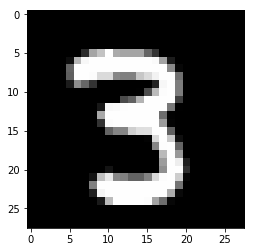

In [242]:
idx = 20121
TestX, TestT = mnist["data"][idx], mnist["target"][idx]
test(NETWORK, TestX, TestT)
test_images = TestX.reshape(28,28)
plt.imshow(test_images, cmap=plt.cm.gray, interpolation='nearest')
np.set_printoptions(precision=2)
NETWORK.dump()